In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def show_data_distribution(dataset, keyname="no name", classes=classes):
    dataset_elems = len(classes)*[0]
    for image, label in dataset:
        dataset_elems[label]+=1
    plt.bar(list(classes), dataset_elems)
    plt.title(keyname)
    plt.show()

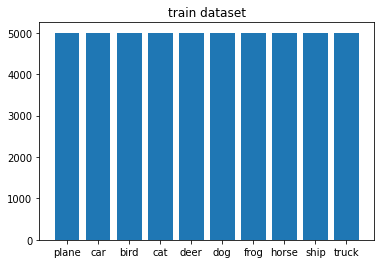

In [5]:
show_data_distribution(trainset, keyname="train dataset")

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [18]:
def train(trainloader, optimizer, net, criterion, epoch):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    print("Finished")
    return net

In [21]:
def test(testloader, net):
    running_loss = 0.0
    net.eval()
    output_logs = []
    label_logs = []
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.numpy()
        outputs = torch.argmax(net(inputs), dim=1).numpy()
        output_logs.append(outputs)
        label_logs.append(labels)
    print("Finished testing")
    return (np.concatenate(output_logs, axis=0), np.concatenate(label_logs, axis=0))

In [22]:
outputs, labels = test(testloader, net)

Finished testing


In [23]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [24]:
def get_metrics(outputs, labels):
    precision = precision_score(labels, outputs, average=None)
    max_precision = np.max(precision)
    min_precision = np.min(precision)
    mean_precision = np.mean(precision)
    
    recall = recall_score(labels, outputs, average=None)
    max_recall = np.max(recall)
    min_recall = np.min(recall)
    mean_recall = np.mean(recall)
    
    accuracy = accuracy_score(labels, outputs)
    return {
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy,
            "max_precision": max_precision,
            "mean_precision": mean_precision,
            "min_precision": min_precision,
            "max_recall": max_recall,
            "mean_recall": mean_recall,
            "min_recall": min_recall
            }


In [25]:
metrics  = get_metrics(outputs, labels)
for label in metrics.keys():
    print(label, metrics[label])

precision [0.66287263 0.57589488 0.34211199 0.3982837  0.4496065  0.45522539
 0.56775362 0.58451786 0.6940649  0.63729565]
recall [0.4892 0.7626 0.5352 0.3156 0.3542 0.4504 0.6268 0.6086 0.6502 0.46  ]
accuracy 0.52528
max_precision 0.694064901793339
mean_precision 0.5367627122560691
min_precision 0.3421119918179494
max_recall 0.7626
mean_recall 0.52528
min_recall 0.3156


In [26]:
def loop(trainloader, testloader, net, optimizer, criterion, epochs=1):
    logs = []
    for i in range(epochs):
        net = train(trainloader, optimizer, net, criterion, epoch=i)
        outputs, labels = test(testloader, net)
        metrics = get_metrics(outputs, labels)
        logs.append(metrics)
    return logs

In [27]:
logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=2)

[1,   200] loss: 1.340
[1,   400] loss: 1.323
[1,   600] loss: 1.330
[1,   800] loss: 1.340
[1,  1000] loss: 1.282
[1,  1200] loss: 1.325
[1,  1400] loss: 1.317
[1,  1600] loss: 1.285
[1,  1800] loss: 1.301
[1,  2000] loss: 1.292
[1,  2200] loss: 1.272
[1,  2400] loss: 1.301
[1,  2600] loss: 1.231
[1,  2800] loss: 1.284
[1,  3000] loss: 1.252
Finished
Finished testing
[2,   200] loss: 1.232
[2,   400] loss: 1.232
[2,   600] loss: 1.210
[2,   800] loss: 1.255
[2,  1000] loss: 1.206
[2,  1200] loss: 1.223
[2,  1400] loss: 1.206
[2,  1600] loss: 1.192
[2,  1800] loss: 1.237
[2,  2000] loss: 1.188
[2,  2200] loss: 1.206
[2,  2400] loss: 1.184
[2,  2600] loss: 1.192
[2,  2800] loss: 1.194
[2,  3000] loss: 1.187
Finished
Finished testing


In [28]:
import random
def long_tail(dataset, classes=10, lamda=1):
    class_indices = list(range(classes))
    random.shuffle(class_indices)
    class_probs = [lamda ** x for x in class_indices]
    select_list = []
    for i, (img, label) in enumerate(dataset):
        if np.random.binomial(1, class_probs[label]):
            select_list.append(i)
    dataset.data=dataset.data[np.array(select_list)]
    dataset.targets=list(dataset.targets[x] for x in select_list)
    return dataset

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


Files already downloaded and verified
Files already downloaded and verified


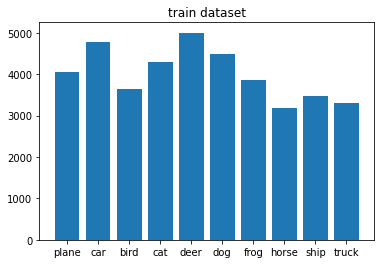

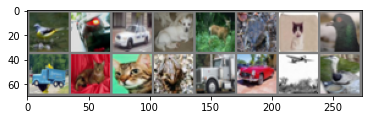

 bird   car   car   dog  deer  frog   cat  bird truck   cat   cat  frog truck   car plane  bird
length of trainset 40073
[1,   200] loss: 2.305
[1,   400] loss: 2.298
[1,   600] loss: 2.291
[1,   800] loss: 2.278
[1,  1000] loss: 2.256
[1,  1200] loss: 2.208
[1,  1400] loss: 2.155
[1,  1600] loss: 2.100
[1,  1800] loss: 2.037
[1,  2000] loss: 1.988
[1,  2200] loss: 1.919
[1,  2400] loss: 1.866
Finished
Finished testing
[2,   200] loss: 1.812
[2,   400] loss: 1.752
[2,   600] loss: 1.724
[2,   800] loss: 1.712
[2,  1000] loss: 1.641
[2,  1200] loss: 1.647
[2,  1400] loss: 1.632
[2,  1600] loss: 1.593
[2,  1800] loss: 1.585
[2,  2000] loss: 1.613
[2,  2200] loss: 1.579
[2,  2400] loss: 1.555
Finished
Finished testing
[3,   200] loss: 1.549
[3,   400] loss: 1.530
[3,   600] loss: 1.491
[3,   800] loss: 1.489
[3,  1000] loss: 1.450
[3,  1200] loss: 1.469
[3,  1400] loss: 1.462
[3,  1600] loss: 1.442
[3,  1800] loss: 1.470
[3,  2000] loss: 1.449
[3,  2200] loss: 1.417
[3,  2400] loss: 1.406

[27,   400] loss: 0.482
[27,   600] loss: 0.509
[27,   800] loss: 0.533
[27,  1000] loss: 0.548
[27,  1200] loss: 0.548
[27,  1400] loss: 0.556
[27,  1600] loss: 0.581
[27,  1800] loss: 0.609
[27,  2000] loss: 0.588
[27,  2200] loss: 0.566
[27,  2400] loss: 0.575
Finished
Finished testing
[28,   200] loss: 0.468
[28,   400] loss: 0.498
[28,   600] loss: 0.521
[28,   800] loss: 0.504
[28,  1000] loss: 0.500
[28,  1200] loss: 0.549
[28,  1400] loss: 0.535
[28,  1600] loss: 0.542
[28,  1800] loss: 0.565
[28,  2000] loss: 0.604
[28,  2200] loss: 0.567
[28,  2400] loss: 0.573
Finished
Finished testing
[29,   200] loss: 0.434
[29,   400] loss: 0.476
[29,   600] loss: 0.480
[29,   800] loss: 0.503
[29,  1000] loss: 0.509
[29,  1200] loss: 0.519
[29,  1400] loss: 0.529
[29,  1600] loss: 0.520
[29,  1800] loss: 0.579
[29,  2000] loss: 0.557
[29,  2200] loss: 0.560
[29,  2400] loss: 0.533
Finished
Finished testing
[30,   200] loss: 0.429
[30,   400] loss: 0.470
[30,   600] loss: 0.494
[30,   800

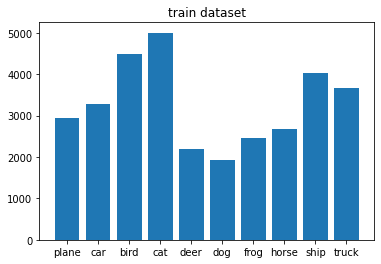

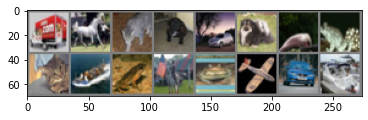

truck horse   cat   dog   car   dog  bird  frog   cat  ship  frog horse  frog plane   car  ship
length of trainset 32660
[1,   200] loss: 2.289
[1,   400] loss: 2.268
[1,   600] loss: 2.250
[1,   800] loss: 2.234
[1,  1000] loss: 2.169
[1,  1200] loss: 2.071
[1,  1400] loss: 2.018
[1,  1600] loss: 1.952
[1,  1800] loss: 1.917
[1,  2000] loss: 1.865
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[2,   200] loss: 1.821
[2,   400] loss: 1.784
[2,   600] loss: 1.720
[2,   800] loss: 1.676
[2,  1000] loss: 1.644
[2,  1200] loss: 1.612
[2,  1400] loss: 1.601
[2,  1600] loss: 1.562
[2,  1800] loss: 1.588
[2,  2000] loss: 1.537
Finished
Finished testing
[3,   200] loss: 1.494
[3,   400] loss: 1.519
[3,   600] loss: 1.471
[3,   800] loss: 1.511
[3,  1000] loss: 1.465
[3,  1200] loss: 1.461
[3,  1400] loss: 1.414
[3,  1600] loss: 1.443
[3,  1800] loss: 1.435
[3,  2000] loss: 1.410
Finished
Finished testing
[4,   200] loss: 1.373
[4,   400] loss: 1.360
[4,   600] loss: 1.370
[4,   800] loss: 1.349
[4,  1000] loss: 1.395
[4,  1200] loss: 1.371
[4,  1400] loss: 1.349
[4,  1600] loss: 1.352
[4,  1800] loss: 1.347
[4,  2000] loss: 1.350
Finished
Finished testing
[5,   200] loss: 1.310
[5,   400] loss: 1.300
[5,   600] loss: 1.285
[5,   800] loss: 1.275
[5,  1000] loss: 1.272
[5,  1200] loss: 1.289
[5,  1400] loss: 1.280
[5,  1600] loss: 1.270
[5,  1800] loss: 1.288
[5,  2000] loss: 1.253
Fi

[33,   600] loss: 0.362
[33,   800] loss: 0.383
[33,  1000] loss: 0.383
[33,  1200] loss: 0.404
[33,  1400] loss: 0.427
[33,  1600] loss: 0.425
[33,  1800] loss: 0.458
[33,  2000] loss: 0.442
Finished
Finished testing
[34,   200] loss: 0.316
[34,   400] loss: 0.341
[34,   600] loss: 0.365
[34,   800] loss: 0.369
[34,  1000] loss: 0.392
[34,  1200] loss: 0.402
[34,  1400] loss: 0.416
[34,  1600] loss: 0.417
[34,  1800] loss: 0.413
[34,  2000] loss: 0.407
Finished
Finished testing
[35,   200] loss: 0.311
[35,   400] loss: 0.308
[35,   600] loss: 0.356
[35,   800] loss: 0.331
[35,  1000] loss: 0.386
[35,  1200] loss: 0.361
[35,  1400] loss: 0.391
[35,  1600] loss: 0.412
[35,  1800] loss: 0.443
[35,  2000] loss: 0.366
Finished
Finished testing
[36,   200] loss: 0.307
[36,   400] loss: 0.300
[36,   600] loss: 0.328
[36,   800] loss: 0.332
[36,  1000] loss: 0.372
[36,  1200] loss: 0.356
[36,  1400] loss: 0.373
[36,  1600] loss: 0.377
[36,  1800] loss: 0.389
[36,  2000] loss: 0.378
Finished
F

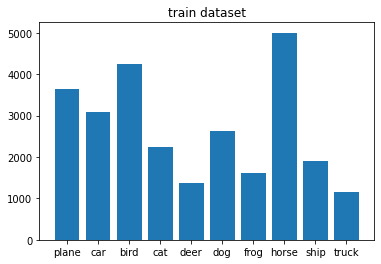

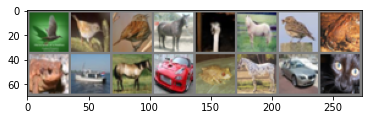

 bird  bird  bird horse  bird horse  bird  frog  frog  ship horse   car  frog horse   car   cat
length of trainset 26884
[1,   200] loss: 2.273
[1,   400] loss: 2.227
[1,   600] loss: 2.200
[1,   800] loss: 2.132
[1,  1000] loss: 2.044
[1,  1200] loss: 1.962
[1,  1400] loss: 1.893
[1,  1600] loss: 1.845
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[2,   200] loss: 1.785
[2,   400] loss: 1.727
[2,   600] loss: 1.691
[2,   800] loss: 1.646
[2,  1000] loss: 1.614
[2,  1200] loss: 1.596
[2,  1400] loss: 1.601
[2,  1600] loss: 1.523
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[3,   200] loss: 1.524
[3,   400] loss: 1.513
[3,   600] loss: 1.517
[3,   800] loss: 1.446
[3,  1000] loss: 1.464
[3,  1200] loss: 1.429
[3,  1400] loss: 1.425
[3,  1600] loss: 1.431
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[4,   200] loss: 1.398
[4,   400] loss: 1.427
[4,   600] loss: 1.385
[4,   800] loss: 1.365
[4,  1000] loss: 1.354
[4,  1200] loss: 1.367
[4,  1400] loss: 1.380
[4,  1600] loss: 1.349
Finished
Finished testing
[5,   200] loss: 1.328
[5,   400] loss: 1.345
[5,   600] loss: 1.326
[5,   800] loss: 1.277
[5,  1000] loss: 1.285
[5,  1200] loss: 1.312
[5,  1400] loss: 1.268
[5,  1600] loss: 1.309
Finished
Finished testing
[6,   200] loss: 1.244
[6,   400] loss: 1.262
[6,   600] loss: 1.269
[6,   800] loss: 1.250
[6,  1000] loss: 1.240
[6,  1200] loss: 1.230
[6,  1400] loss: 1.217
[6,  1600] loss: 1.214
Finished
Finished testing
[7,   200] loss: 1.165
[7,   400] loss: 1.220
[7,   600] loss: 1.170
[7,   800] loss: 1.182
[7,  1000] loss: 1.169
[7,  1200] loss: 1.196
[7,  1400] loss: 1.171
[7,  1600] loss: 1.179
Finished
Finished testing
[8,   200] loss: 1.093
[8,   400] loss: 1.162
[8,   600] loss: 1.155
[8,   800] loss: 1.131
[8,  1000] loss: 1.143
[8,  1200] loss: 1.150
[8,  1400] loss: 1.126

Finished
Finished testing
[42,   200] loss: 0.217
[42,   400] loss: 0.192
[42,   600] loss: 0.205
[42,   800] loss: 0.208
[42,  1000] loss: 0.242
[42,  1200] loss: 0.292
[42,  1400] loss: 0.280
[42,  1600] loss: 0.284
Finished
Finished testing
[43,   200] loss: 0.178
[43,   400] loss: 0.199
[43,   600] loss: 0.202
[43,   800] loss: 0.230
[43,  1000] loss: 0.258
[43,  1200] loss: 0.279
[43,  1400] loss: 0.274
[43,  1600] loss: 0.285
Finished
Finished testing
[44,   200] loss: 0.214
[44,   400] loss: 0.183
[44,   600] loss: 0.232
[44,   800] loss: 0.234
[44,  1000] loss: 0.236
[44,  1200] loss: 0.234
[44,  1400] loss: 0.274
[44,  1600] loss: 0.285
Finished
Finished testing
[45,   200] loss: 0.197
[45,   400] loss: 0.197
[45,   600] loss: 0.219
[45,   800] loss: 0.208
[45,  1000] loss: 0.280
[45,  1200] loss: 0.238
[45,  1400] loss: 0.241
[45,  1600] loss: 0.282
Finished
Finished testing
[46,   200] loss: 0.199
[46,   400] loss: 0.199
[46,   600] loss: 0.184
[46,   800] loss: 0.184
[46,  

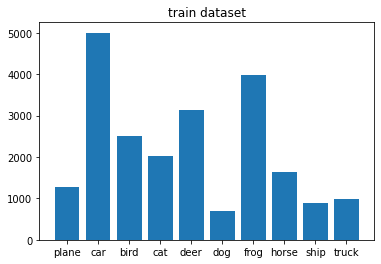

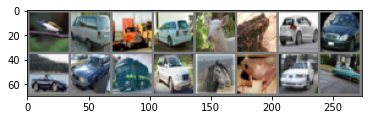

 bird   car truck   car  deer  frog   car   car   car   car truck   car horse  frog   car   car
length of trainset 22137
[1,   200] loss: 2.252
[1,   400] loss: 2.171
[1,   600] loss: 2.106
[1,   800] loss: 2.068
[1,  1000] loss: 1.935
[1,  1200] loss: 1.853
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[2,   200] loss: 1.681
[2,   400] loss: 1.695
[2,   600] loss: 1.676
[2,   800] loss: 1.646
[2,  1000] loss: 1.646
[2,  1200] loss: 1.576
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[3,   200] loss: 1.553
[3,   400] loss: 1.531
[3,   600] loss: 1.519
[3,   800] loss: 1.496
[3,  1000] loss: 1.513
[3,  1200] loss: 1.494
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[4,   200] loss: 1.451
[4,   400] loss: 1.409
[4,   600] loss: 1.392
[4,   800] loss: 1.433
[4,  1000] loss: 1.400
[4,  1200] loss: 1.350
Finished
Finished testing
[5,   200] loss: 1.298
[5,   400] loss: 1.323
[5,   600] loss: 1.303
[5,   800] loss: 1.313
[5,  1000] loss: 1.310
[5,  1200] loss: 1.343
Finished
Finished testing
[6,   200] loss: 1.243
[6,   400] loss: 1.246
[6,   600] loss: 1.278
[6,   800] loss: 1.238
[6,  1000] loss: 1.243
[6,  1200] loss: 1.248
Finished
Finished testing
[7,   200] loss: 1.160
[7,   400] loss: 1.178
[7,   600] loss: 1.177
[7,   800] loss: 1.163
[7,  1000] loss: 1.227
[7,  1200] loss: 1.214
Finished
Finished testing
[8,   200] loss: 1.162
[8,   400] loss: 1.121
[8,   600] loss: 1.145
[8,   800] loss: 1.146
[8,  1000] loss: 1.126
[8,  1200] loss: 1.137
Finished
Finished testing
[9,   200] loss: 1.104
[9,   400] loss: 1.115
[9,   600] loss: 1.094
[9,   800] loss: 1.088
[9,  1000] loss: 1.091
[9,  1200] loss: 1.065
Finished
Finished testing
[10,   200] loss

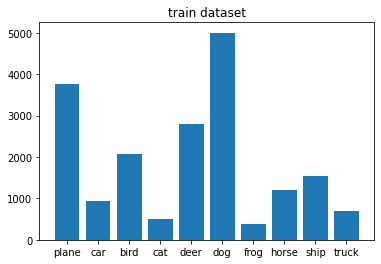

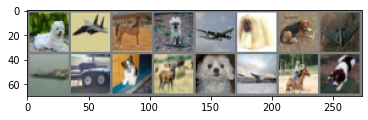

  dog plane horse   dog plane   dog   dog plane  ship truck   dog  deer   dog plane horse   dog
length of trainset 18911
[1,   200] loss: 2.241
[1,   400] loss: 2.054
[1,   600] loss: 2.007
[1,   800] loss: 1.959
[1,  1000] loss: 1.895
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[2,   200] loss: 1.774
[2,   400] loss: 1.743
[2,   600] loss: 1.713
[2,   800] loss: 1.670
[2,  1000] loss: 1.687
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[3,   200] loss: 1.590
[3,   400] loss: 1.571
[3,   600] loss: 1.528
[3,   800] loss: 1.512
[3,  1000] loss: 1.483
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[4,   200] loss: 1.432
[4,   400] loss: 1.390
[4,   600] loss: 1.397
[4,   800] loss: 1.400
[4,  1000] loss: 1.379
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[5,   200] loss: 1.351
[5,   400] loss: 1.316
[5,   600] loss: 1.276
[5,   800] loss: 1.320
[5,  1000] loss: 1.295
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[6,   200] loss: 1.274
[6,   400] loss: 1.267
[6,   600] loss: 1.224
[6,   800] loss: 1.223
[6,  1000] loss: 1.249
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[7,   200] loss: 1.234
[7,   400] loss: 1.197
[7,   600] loss: 1.189
[7,   800] loss: 1.201
[7,  1000] loss: 1.163
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[8,   200] loss: 1.140
[8,   400] loss: 1.137
[8,   600] loss: 1.173
[8,   800] loss: 1.145
[8,  1000] loss: 1.130
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[9,   200] loss: 1.118
[9,   400] loss: 1.115
[9,   600] loss: 1.075
[9,   800] loss: 1.090
[9,  1000] loss: 1.087
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[10,   200] loss: 1.072
[10,   400] loss: 1.045
[10,   600] loss: 1.063
[10,   800] loss: 1.066
[10,  1000] loss: 1.047
Finished
Finished testing
[11,   200] loss: 1.019
[11,   400] loss: 1.041
[11,   600] loss: 1.029
[11,   800] loss: 1.010
[11,  1000] loss: 1.010
Finished
Finished testing
[12,   200] loss: 0.978
[12,   400] loss: 1.013
[12,   600] loss: 0.989
[12,   800] loss: 1.003
[12,  1000] loss: 0.968
Finished
Finished testing


/Users/shrinivas/miniconda3/envs/commentaries/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[13,   200] loss: 0.912
[13,   400] loss: 0.970
[13,   600] loss: 0.956
[13,   800] loss: 0.969
[13,  1000] loss: 0.969
Finished
Finished testing
[14,   200] loss: 0.918
[14,   400] loss: 0.899
[14,   600] loss: 0.934
[14,   800] loss: 0.942
[14,  1000] loss: 0.932
Finished
Finished testing
[15,   200] loss: 0.866
[15,   400] loss: 0.893
[15,   600] loss: 0.876
[15,   800] loss: 0.893
[15,  1000] loss: 0.931
Finished
Finished testing
[16,   200] loss: 0.840
[16,   400] loss: 0.849
[16,   600] loss: 0.859
[16,   800] loss: 0.841
[16,  1000] loss: 0.862
Finished
Finished testing
[17,   200] loss: 0.799
[17,   400] loss: 0.826
[17,   600] loss: 0.812
[17,   800] loss: 0.844
[17,  1000] loss: 0.847
Finished
Finished testing
[18,   200] loss: 0.781
[18,   400] loss: 0.773
[18,   600] loss: 0.820
[18,   800] loss: 0.815
[18,  1000] loss: 0.799
Finished
Finished testing
[19,   200] loss: 0.726
[19,   400] loss: 0.757
[19,   600] loss: 0.763
[19,   800] loss: 0.773
[19,  1000] loss: 0.783
Fini

In [32]:
logs_by_lamda = []
for lamda in [0.95, 0.9, 0.85, 0.8, 0.75]:
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    trainset = long_tail(trainset, 10, lamda)
    show_data_distribution(trainset, keyname="train dataset")
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

    print("length of trainset", len(trainset))
    
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=50)
    logs_by_lamda.append({lamda: logs})

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


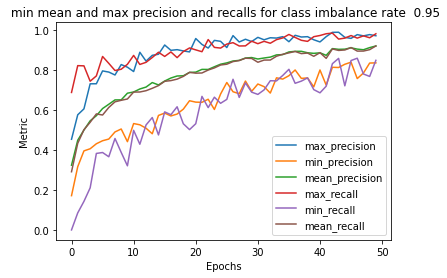

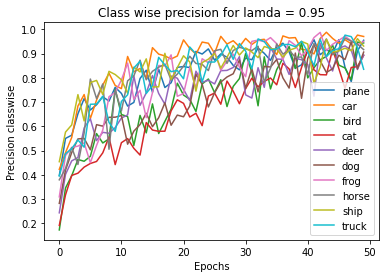

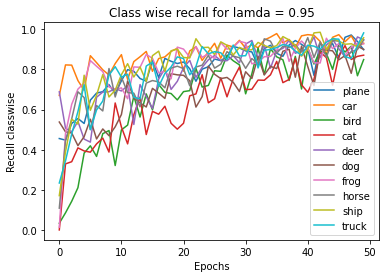

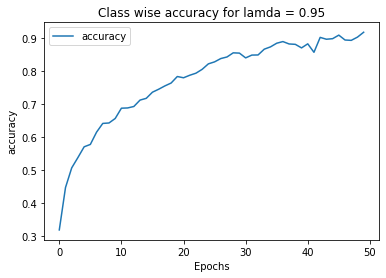


('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


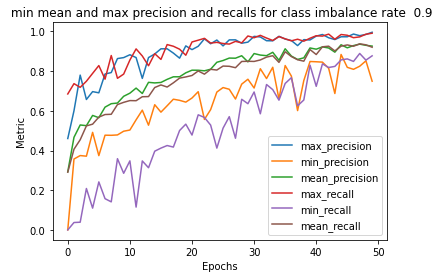

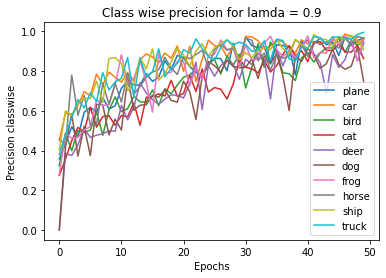

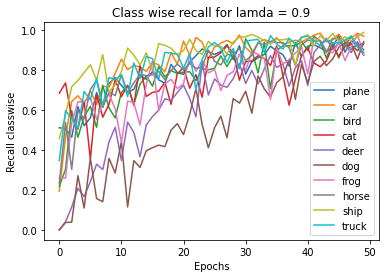

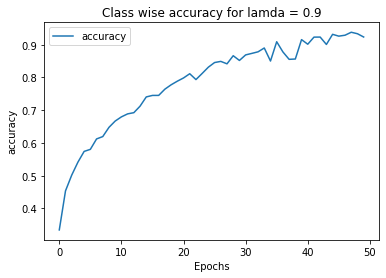


('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


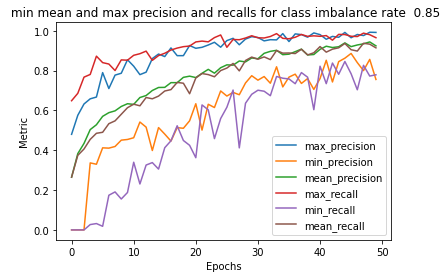

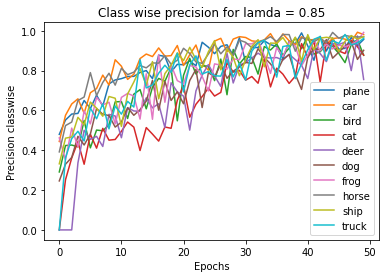

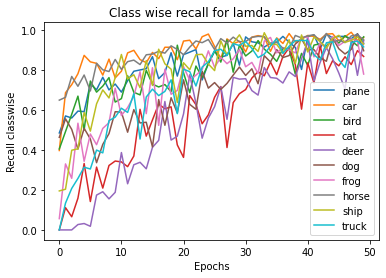

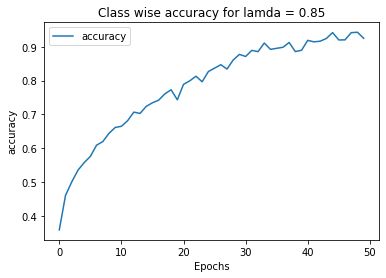


('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


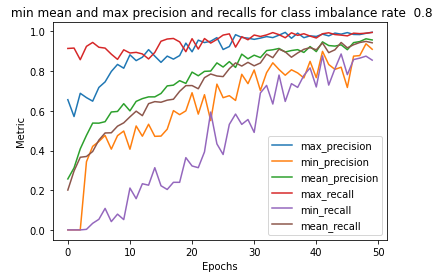

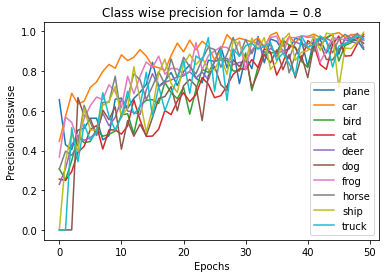

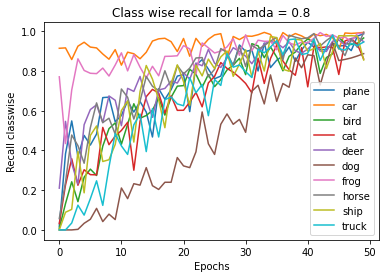

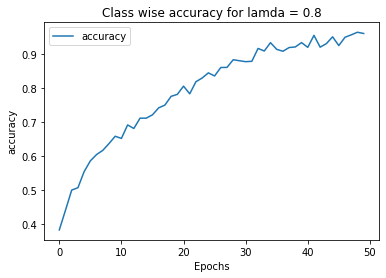


('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


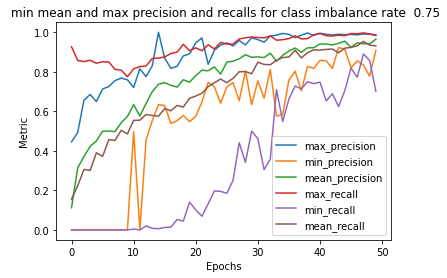

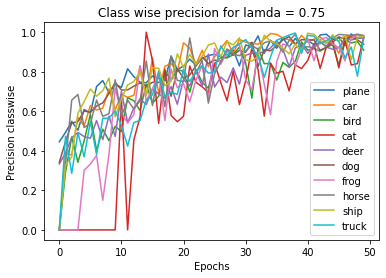

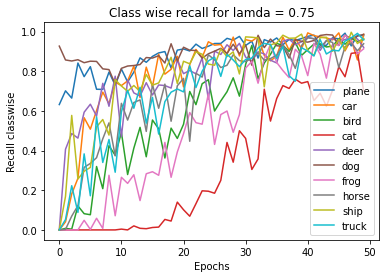

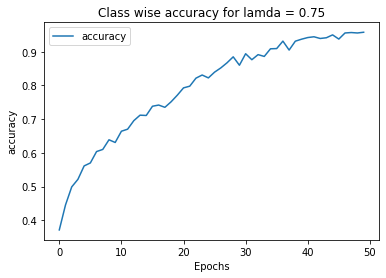

In [47]:
def plot_log(logs, lamda, num_classes=10, classes=classes):
    print(classes)
    precision = [x['precision'] for x in logs]
    recall = [x['recall'] for x in logs]
    accuracy = [x['accuracy'] for x in logs]

    len_logs = len(accuracy)

    max_precision = [x['max_precision'] for x in logs]
    min_precision = [x['min_precision'] for x in logs]
    mean_precision = [x['mean_precision'] for x in logs]

    max_recall = [x['max_recall'] for x in logs]
    min_recall = [x['min_recall'] for x in logs]
    mean_recall = [x['mean_recall'] for x in logs]

    plt.plot(list(range(len(max_precision))), max_precision, label = "max_precision")
    plt.plot(list(range(len(min_precision))), min_precision, label = "min_precision")
    plt.plot(list(range(len(mean_precision))), mean_precision, label = "mean_precision")

    plt.plot(list(range(len(max_recall))), max_recall, label = "max_recall")
    plt.plot(list(range(len(min_recall))), min_recall, label = "min_recall")
    plt.plot(list(range(len(mean_recall))), mean_recall, label = "mean_recall")
    
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.title(' min mean and max precision and recalls for class imbalance rate  '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()
    
    
    precision = np.array(precision)
    recall = np.array(recall)
    for i in range(num_classes):
        plt.plot(list(range(len_logs)), precision[:, i].tolist(), label = classes[i])
        
    plt.xlabel('Epochs')
    plt.ylabel('Precision classwise')
    plt.title('Class wise precision for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()
    
    for i in range(num_classes):
        plt.plot(list(range(len_logs)), recall[:, i].tolist(), label = classes[i])
        
    plt.xlabel('Epochs')
    plt.ylabel('Recall classwise')
    plt.title('Class wise recall for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(list(range(len(accuracy))), accuracy, label = "accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.title('Class wise accuracy for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()
    
for log in logs_by_lamda:
    lamda = list(log.keys())[0]
    plot_log(log[lamda], lamda)
    print("")